https://github.com/richzhang/colorization/blob/master/colorization/demo/colorization_demo_v2.ipynb

https://arxiv.org/pdf/1603.08511.pdf

In [4]:
import cv2 # opencv 3.4.2+ required
import numpy as np
import matplotlib.pyplot as plt

import urllib.request
import os

In [6]:
# download pretrained models
os.makedirs('models', exist_ok=True)
urllib.request.urlretrieve('https://github.com/richzhang/colorization/blob/master/colorization/resources/pts_in_hull.npy?raw=true', './models/pts_in_hull.npy')
urllib.request.urlretrieve('https://raw.githubusercontent.com/richzhang/colorization/master/colorization/models/colorization_deploy_v2.prototxt', './models/colorization_deploy_v2.prototxt')
urllib.request.urlretrieve('http://eecs.berkeley.edu/~rich.zhang/projects/2016_colorization/files/demo_v2/colorization_release_v2.caffemodel', './models/colorization_release_v2.caffemodel')
urllib.request.urlretrieve('http://eecs.berkeley.edu/~rich.zhang/projects/2016_colorization/files/demo_v2/colorization_release_v2_norebal.caffemodel', './models/colorization_release_v2_norebal.caffemodel')

('./models/colorization_release_v2_norebal.caffemodel',
 <http.client.HTTPMessage at 0x12b076240>)

In [47]:
proto = './models/colorization_deploy_v2.prototxt'
weights = './models/colorization_release_v2_norebal.caffemodel'
# load cluster centers
pts_in_hull = np.load('./models/pts_in_hull.npy')
pts_in_hull = pts_in_hull.transpose().reshape(2, 313, 1, 1).astype(np.float32)

# load model
net = cv2.dnn.readNetFromCaffe(proto, weights)
# net.getLayerNames()

# populate cluster centers as 1x1 convolution kernel
net.getLayer(net.getLayerId('class8_ab')).blobs = [pts_in_hull]
net.getLayer(net.getLayerId('conv8_313_rh')).blobs = [np.full((1, 313), 2.606, np.float32)]

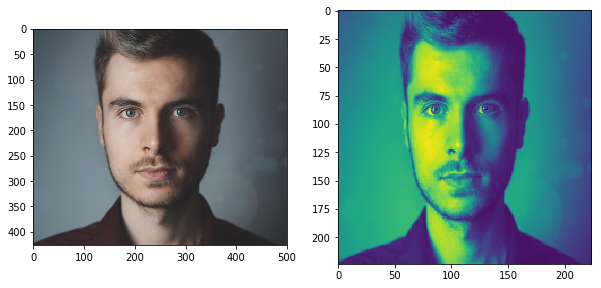

In [54]:
img = cv2.imread('img/sample_0.jpg')
# convert BGR to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img_rgb = img.copy()

# normalize input
img_rgb = (img_rgb / 255.).astype(np.float32)

# convert RGB to LAB
img_lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2Lab)
# only L channel to be used
img_l = img_lab[:, :, 0]

input_img = cv2.resize(img_l, (224, 224))
input_img -= 50 # subtract 50 for mean-centering

# plot images
fig = plt.figure(figsize=(10, 5))
fig.add_subplot(1, 2, 1)
plt.imshow(img_rgb)
fig.add_subplot(1, 2, 2)
plt.imshow(input_img)

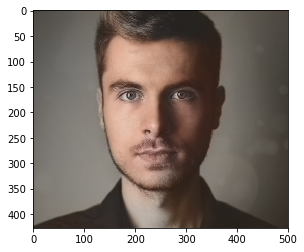

In [55]:
# prediction
net.setInput(cv2.dnn.blobFromImage(input_img))

pred = net.forward()[0,:,:,:].transpose((1, 2, 0))

# resize to original image shape
pred_resize = cv2.resize(pred, (img.shape[1], img.shape[0]))

# concatenate with original image L
pred_lab = np.concatenate([img_l[:, :, np.newaxis], pred_resize], axis=2)

# convert LAB to RGB
pred_rgb = cv2.cvtColor(pred_lab, cv2.COLOR_Lab2RGB)
pred_rgb = np.clip(pred_rgb, 0, 1) * 255
pred_rgb = pred_rgb.astype(np.uint8)

# plot prediction result
plt.imshow(pred_rgb)